# Ad-hoc Pulse Shape Simulation Using Cyclic Positional U-Net (CPU-Net)
- This is the source code of training and validating the performance of CPU-Net
- This code should run on a standard python environment with PyTorch installed.
    - we recommend installing a small gadget `tqdm` to monitor the time/progress of `for` loops. Installation can be done with `pip install tqdm --user`
    - If the user do not wish to install `tqdm`, please delete the import code and tdqm() wrapper
- This repository only contains the script of the model, training data has to be downloaded separately at [here](https://drive.google.com/file/d/1JcgQy6snavgcRetFAGl0QM3OAmPTqKqt/view?usp=sharing).
- Once downloaded, please unzip it and dump it into the same folder with this script

In [5]:
import os
import time
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import signal, sparse
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch import einsum
import math
import itertools

# Loading CPU-Net and support functions
from tools import (calc_current_amplitude, process_all_waveforms, calculate_tn, check_peak_alignment,
                   get_tail_slope, inf_train_gen, LambdaLR, weights_init_normal, select_quantile, calculate_iou)
from dataset import SplinterDataset, SEQ_LEN, LSPAN, RSPAN
from network import PositionalUNet, RNN

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Print whether CUDA is available or not
print(f"CUDA available: {cuda_available}")
# If CUDA is available, print the CUDA device count and device name(s)
if cuda_available:
    print(f"Number of CUDA Devices: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
torch.cuda.empty_cache()
home_dir='/nas/longleaf/home/kbhimani/'
scratch_dir = '/work/users/k/b/kbhimani/'
save_dir = "/work/users/k/b/kbhimani/CPU-Net"
eng_peak='fep' # training peak

CUDA available: True
Number of CUDA Devices: 1
CUDA Device 0: NVIDIA A100-PCIE-40GB MIG 2g.10gb


Below are the hyperparameters for model training, it is recommended to tune them for different detectors and operating conditions

In [3]:
BATCH_SIZE = 32 # batch size, each batch is drawn from the infinite train generator
baseline_len = 200 # number of samples assigned to baseline portions
rising_edge_len = 250 # number of samples assigned to rising edge
tail_len = 350 # number of samples assigned to tail 
baseline_weight=3.0 # weight given to baseline portion of the waveform in loss function
ris_edge_weight=10.0 # weight giveing to rising edge of the waveform in loss function
tail_weight=7.0 # weight giving to the RC decay tail of the wavefrom in loss function
ITERS = 7000 # max number of interations to run
DECAY = 1000 # iteration at which learning rate starts to decay
LRATE_Gen =1e-3 # learning rate of the generator
LRATE_Disc =1e-3 # learning rate of the discriminator
cyc_loss_weight = 20 # weight of the cycle consistent loss in training, eg loss(sim->data->sim)
iden_loss_weight = 5 # weight of idenentity loss, for example ATN(data)- data
gan_loss_weight = 9 # weight of the generator loss. ATN(sim) - data
max_grad_norm = 100 # Maximum norm for gradient clipping
w_decay = 1e-4 # weight decay in the optimizers
n_disc_iters = 30  # Set the number of iterations after which discriminators will be updated
max_sample = 2e5 # numbers of samples to used for training

# Check if DECAY is less than ITERS
if DECAY >= ITERS:
    raise ValueError("DECAY must be less than ITERS to avoid division by zero in the learning rate scheduler.")

Our goal is to train on FEP peak which contains both multisite and single site events, and validate on DEP which is primaraly single site and SEP which is primaraliy multi site

In [7]:
det_pulses=home_dir+f'CPU-Net/training_data/{eng_peak}_wf_ornl.pickle'
sim_pulses=home_dir+f'CPU-Net/training_data/{eng_peak}_wf_sim.pickle'

## Load Dataset
- This function loads the siggen simulation and detector pulse dataset, splitting them into training and validation data loader
- Simulated pulses are generated in Siggen
- Detector pulses are collected from a local Ge detector

 U-Net Training
- target_real: a vector of 1, used for GAN discriminator training
- target_fake: a vector of 0, used for GAN discriminator training

- Create infinite train generator. This generator can be called an infinite amount of time to draw from training dataset (with repetition)

- Create network structures and feed them into the DEVICE defined above
    - A: Detector Pulses
    - B: Simulated Pulses
    - BtoA: Ad-hoc Translation Network (Simulation to Data)
    - AtoB: Inverse Ad-hoc Translation Network (Data to Simulation)
    
SplinterDataset class reads waveform data from pickle files, applies data cleaning cuts based on chi-squared and tail slope (tau) values, performs necessary waveform padding and normalization, and integrates with PyTorch's DataLoader for batch processing.
To skip the data cleaning cuts, set a really high value such as chi_squared_threshold=100, popt_threshold_under=-10, popt_threshold_over=10
Data laoder also outputs chi squared and taus values from the dataset which can then be used to set a cut

In [8]:
# This block loads the FEP data for training
chi_squared_cut = 0.0022
tau_cut_low = -2.98e-4
tau_cut_high = -2.88e-4
dataset = SplinterDataset(det_pulses, sim_pulses, n_max=max_sample, chi_squared_threshold=chi_squared_cut, popt_threshold_under=tau_cut_low, popt_threshold_over=tau_cut_high)
validation_split = 0.0
shuffle_dataset = True
random_seed= 42222
indices = np.arange(len(dataset))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
split = int(validation_split*len(dataset))
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
train_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler,  drop_last=True)
test_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_sampler,  drop_last=True)
data = inf_train_gen(train_loader)
test_loader = train_loader

Chi squared cut is 0.0022
Tail slope cut over is -0.000288
Tail slope cut under is -0.000298
10000 waveforms loaded from data.
20000 waveforms loaded from data.
30000 waveforms loaded from data.
40000 waveforms loaded from data.
50000 waveforms loaded from data.
60000 waveforms loaded from data.
70000 waveforms loaded from data.
80000 waveforms loaded from data.
90000 waveforms loaded from data.
100000 waveforms loaded from data.
Number of Data events: 107342
10000 waveforms loaded from simulations.
20000 waveforms loaded from simulations.
30000 waveforms loaded from simulations.
40000 waveforms loaded from simulations.
50000 waveforms loaded from simulations.
60000 waveforms loaded from simulations.
70000 waveforms loaded from simulations.
80000 waveforms loaded from simulations.
90000 waveforms loaded from simulations.
100000 waveforms loaded from simulations.
110000 waveforms loaded from simulations.
Number of Simulations events 110403


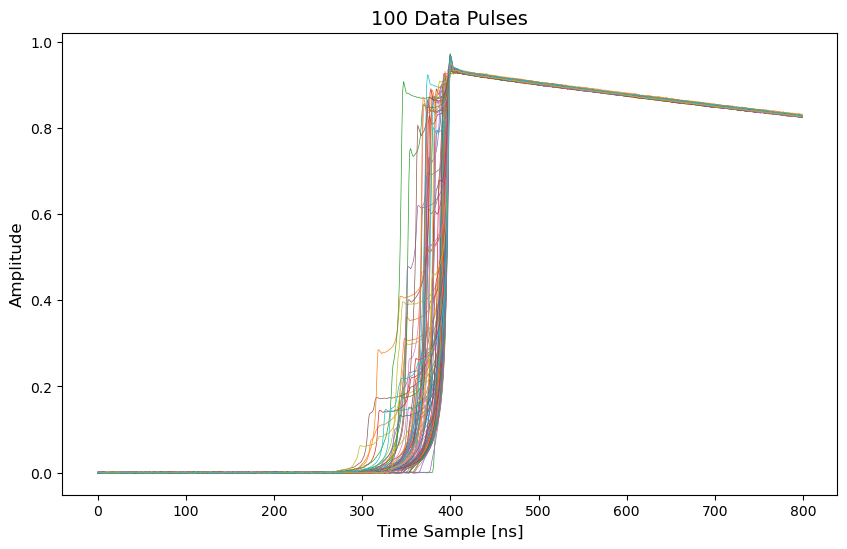

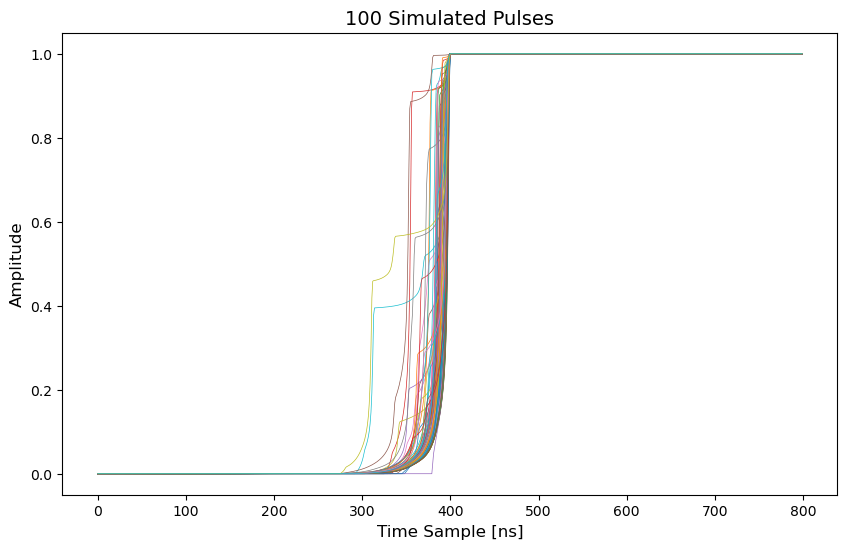

In [9]:
dataset.plot_waveform()

214741


Text(0.5, 1.0, 'Distribution of linear fit to -log Waveforms tail')

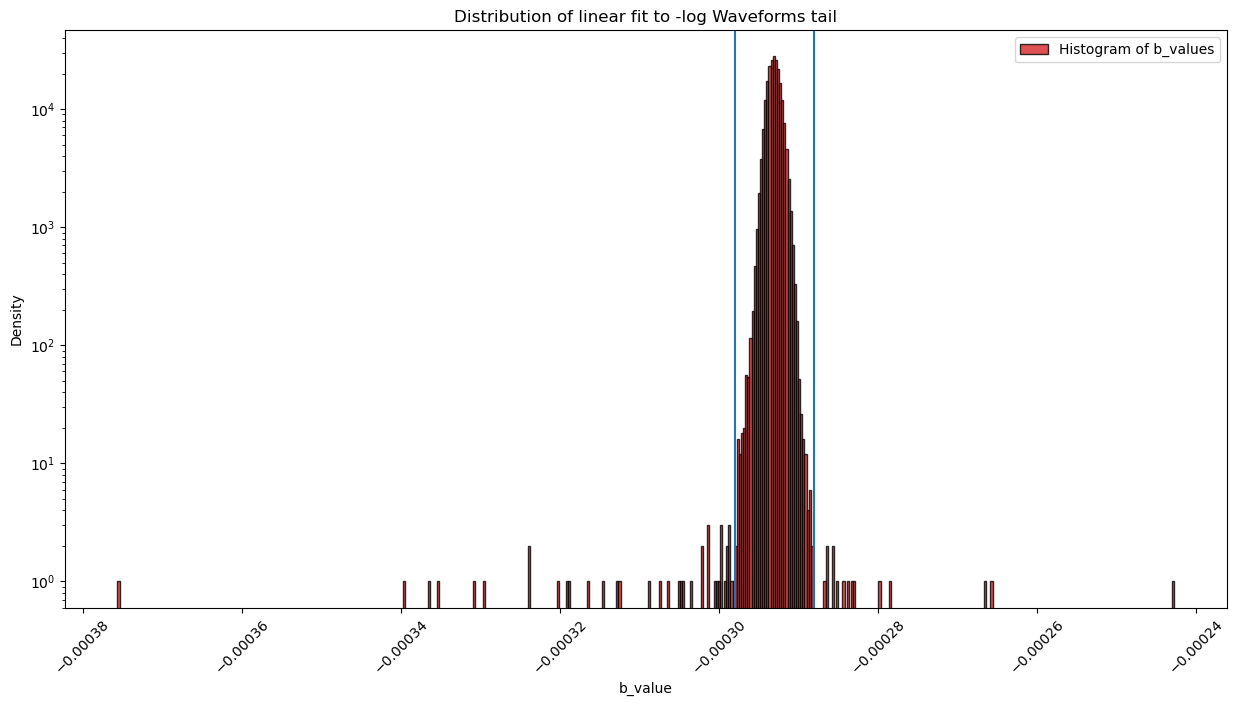

In [10]:
linear_b_values = dataset.tau_fits
print(len(linear_b_values))
plt.figure(figsize=(15,7.5))
plt.hist(linear_b_values, bins=500, color='tab:red', label="Histogram of b_values",alpha=0.8, edgecolor='k')
plt.legend()
plt.xlabel('b_value')
plt.ylabel('Density')
plt.yscale('log')
plt.axvline(tau_cut_low)
plt.axvline(tau_cut_high)

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.title('Distribution of linear fit to -log Waveforms tail')
# np.save('plot_data/linear_b_values.npy', dataset.tau_fits)
# plt.savefig("figs/chi_squared.png",dpi=200)


(array([0.    , 0.0025, 0.005 , 0.0075, 0.01  , 0.0125, 0.015 , 0.0175,
        0.02  ]),
 [Text(0.0, 0, '0.0000'),
  Text(0.0025, 0, '0.0025'),
  Text(0.005, 0, '0.0050'),
  Text(0.0075, 0, '0.0075'),
  Text(0.01, 0, '0.0100'),
  Text(0.0125, 0, '0.0125'),
  Text(0.015, 0, '0.0150'),
  Text(0.0175, 0, '0.0175'),
  Text(0.02, 0, '0.0200')])

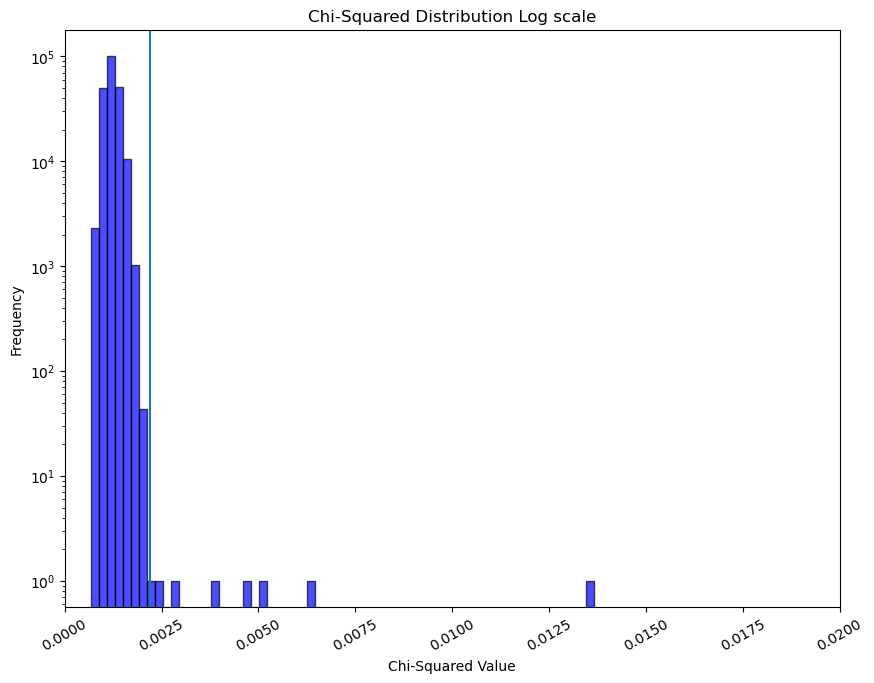

In [11]:
# An example to set chi squared cuts
plt.figure(figsize=(10,7.5))
chi_squared = dataset.chi_squared_coeff

plt.hist(chi_squared, bins=100, color='b', alpha=0.7, edgecolor='k')
plt.xlim(0, 2e-2)
plt.title('Chi-Squared Distribution Log scale')
plt.xlabel('Chi-Squared Value')
plt.yscale('log')
plt.ylabel('Frequency')
plt.axvline(chi_squared_cut)
plt.xticks(rotation=30)  # Rotate the x-axis labels for better readability
# np.save('plot_data/chi_squared_coeff.npy', dataset.chi_squared_coeff)

# plt.savefig("figs/chi_squared.png",dpi=200)

3169


Text(0, 0.5, 'ADC counts')

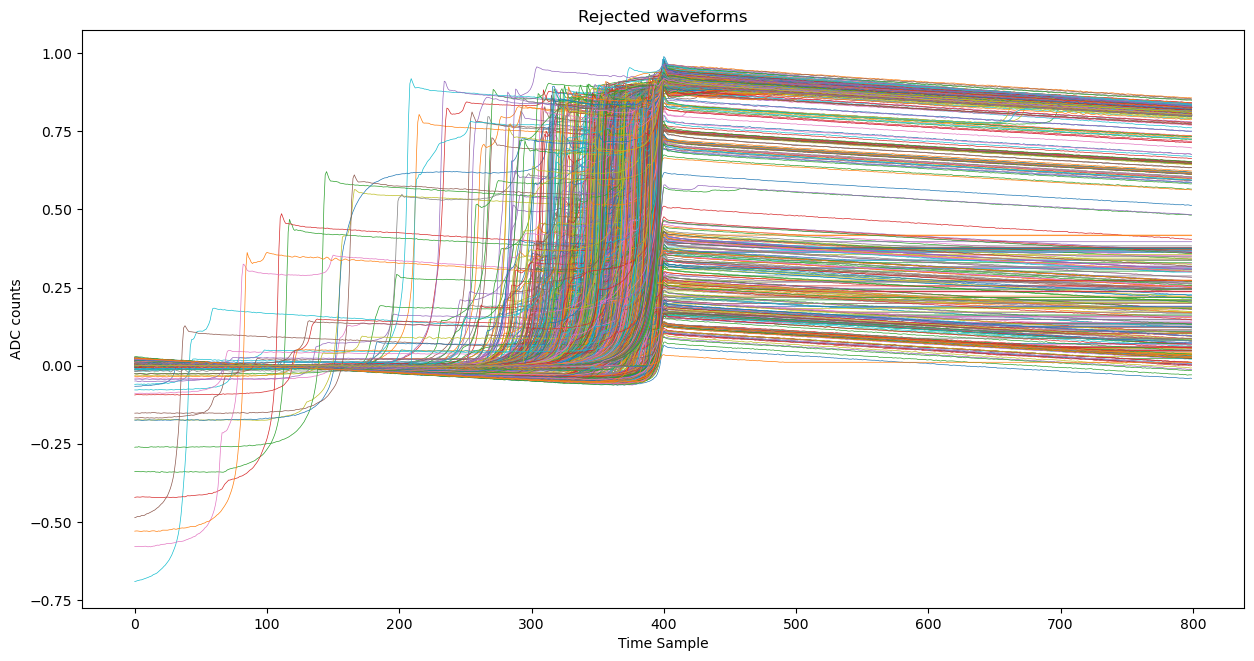

In [12]:
# Plots the rejected waveform from FEP training dataset
print(len(dataset.rejected_wf))
plt.figure(figsize=(15,7.5))
for i in range(len(dataset.rejected_wf)):
    waveform = dataset.rejected_wf[i]
    plt.plot(waveform,linewidth=0.5)
plt.title("Rejected waveforms")
plt.xlabel("Time Sample")
# plt.axhline(y=0.85)
plt.ylabel("ADC counts")

- Create loss function and set up optimizer
    - BCELoss for discriminator
    - WFDist is a special L1loss where additional weight is added to the rising and falling edge of the waveform

In [13]:
class WFDist(nn.Module):
    '''
    Waveform Distance, this is a special type of L1 loss which gives more weight to the
    rising and falling edge of each pulse
    baseline(0,250) rising edge=(250,500), tail=(500,800)

    '''
    def __init__(self, baseline_weight, ris_edge_weight, tail_weight):
        super(WFDist, self).__init__()
        self.criterion = nn.L1Loss()
        self.weight = torch.tensor([baseline_weight]*baseline_len+[ris_edge_weight]*rising_edge_len+[tail_weight]*tail_len).to(DEVICE)

    def forward(self, x1, x2):
        loss_out = 0.0
        for i in range(x1.size(0)):
            loss_out += self.criterion(x1[i].view(-1)*self.weight, x2[i].view(-1)*self.weight)#/self.weight.sum()
        return loss_out/x1.size(0)

In [14]:
import torch
import itertools
import torch.nn as nn

# Target tensors for real and fake labels
target_real = torch.ones(BATCH_SIZE, 1).to(DEVICE)
target_fake = torch.zeros(BATCH_SIZE, 1).to(DEVICE)

# Network definitions
netG_A2B = PositionalUNet()  # Generator from Data to Simulations (ATN)
netG_B2A = PositionalUNet()  # Generator from Simulations to Data (IATN)
netD_A = RNN().apply(weights_init_normal)  # Discriminator for data-like pulses
netD_B = RNN().apply(weights_init_normal)  # Discriminator for simulation-like pulses

# Move networks to device
netG_A2B.to(DEVICE)
netG_B2A.to(DEVICE)
netD_A.to(DEVICE)
netD_B.to(DEVICE)

# Loss functions
criterion_GAN = nn.BCELoss().to(DEVICE)
criterion_cycle = WFDist(baseline_weight, ris_edge_weight, tail_weight).to(DEVICE)
criterion_identity = WFDist(baseline_weight, ris_edge_weight, tail_weight).to(DEVICE)

# Optimizers using AdamW
optimizer_G = torch.optim.AdamW(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), lr=LRATE_Gen, betas=(0.5, 0.999), weight_decay=w_decay)
optimizer_D_A = torch.optim.AdamW(netD_A.parameters(), lr=LRATE_Disc, betas=(0.5, 0.999), weight_decay=w_decay)
optimizer_D_B = torch.optim.AdamW(netD_B.parameters(), lr=LRATE_Disc, betas=(0.5, 0.999), weight_decay=w_decay)

# Learning rate schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(ITERS, 0, DECAY).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(ITERS, 0, DECAY).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(ITERS, 0, DECAY).step)

# Count and print trainable parameters for each model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters in netG_A2B: {count_parameters(netG_A2B)}")
print(f"Total trainable parameters in netG_B2A: {count_parameters(netG_B2A)}")
print(f"Total trainable parameters in netD_A: {count_parameters(netD_A)}")
print(f"Total trainable parameters in netD_B: {count_parameters(netD_B)}")


Total trainable parameters in netG_A2B: 7213781
Total trainable parameters in netG_B2A: 7213781
Total trainable parameters in netD_A: 130817
Total trainable parameters in netD_B: 130817


#real A is data, real B is simulations
#A2B translates data to sim B2A translates sim to data

In [ ]:
import os

label_smoothing = 1
os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

# Function to check for NaN values and stop training if found
def check_for_nan(tensor, name):
    if torch.isnan(tensor).any():
        print(f"NaN detected in {name}. Stopping training.")
        return True
    return False

# Initialize lists to store loss values
losses_G = []
losses_D_A = []
losses_D_B = []
losses_GAN_A2B = []
losses_GAN_B2A = []
losses_identity_A = []
losses_identity_B = []
losses_cycle_ABA = []
losses_cycle_BAB = []
learning_rates_G = []
# l1_data_sim = []

for iteration in tqdm(range(ITERS)):
    netG_A2B.train()
    netG_B2A.train()

    #########################
    # A: Detector Pulses
    # B: Simulated Pulses
    #########################

    real_A, real_B = next(data)
    real_A = real_A.to(DEVICE).float()
    real_B = real_B.to(DEVICE).float()

    # Check for NaN values in real pulses
    if check_for_nan(real_A, "real_A") or check_for_nan(real_B, "real_B"):
        break

    ###### Generators A2B and B2A ######
    optimizer_G.zero_grad()

    # Identity loss
    same_B = netG_A2B(real_B)
    if check_for_nan(same_B, "same_B"):
        break
    loss_identity_B = criterion_identity(same_B, real_B) * iden_loss_weight

    same_A = netG_B2A(real_A)
    if check_for_nan(same_A, "same_A"):
        break
    loss_identity_A = criterion_identity(same_A, real_A) * iden_loss_weight

    # GAN loss
    fake_B = netG_A2B(real_A)
    if check_for_nan(fake_B, "fake_B"):
        break
    pred_fake = netD_B(fake_B)
    loss_GAN_A2B = criterion_GAN(pred_fake, target_real * label_smoothing) * gan_loss_weight

    fake_A = netG_B2A(real_B)
    if check_for_nan(fake_A, "fake_A"):
        break
    pred_fake = netD_A(fake_A)
    loss_GAN_B2A = criterion_GAN(pred_fake, target_real * label_smoothing) * gan_loss_weight

    # Cycle loss
    recovered_A = netG_B2A(fake_B)
    if check_for_nan(recovered_A, "recovered_A"):
        break
    loss_cycle_ABA = criterion_cycle(recovered_A, real_A) * cyc_loss_weight

    recovered_B = netG_A2B(fake_A)
    if check_for_nan(recovered_B, "recovered_B"):
        break
    loss_cycle_BAB = criterion_cycle(recovered_B, real_B) * cyc_loss_weight

    # l1_sim = F.l1_loss(real_A, fake_A)
    # if check_for_nan(l1_sim, "l1_sim"):
    #     break

    # Total loss for generators
    loss_G = (
        loss_identity_A
        + loss_identity_B
        + loss_cycle_ABA
        + loss_cycle_BAB
        + loss_GAN_A2B
        + loss_GAN_B2A
    )
    if check_for_nan(loss_G, "loss_G"):
        break
    loss_G.backward()

    # Apply gradient clipping for the generators
    torch.nn.utils.clip_grad_norm_(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), max_grad_norm)

    optimizer_G.step()

    # Update discriminators every n_disc_iters iterations
    if iteration % n_disc_iters  == 0 : #or iteration>5000
        ###### Discriminator A (Detector Pulses) ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        if check_for_nan(pred_real, "pred_real (Discriminator A)"):
            break
        loss_D_real = criterion_GAN(pred_real, target_real * label_smoothing)

        # Fake loss
        pred_fake = netD_A(fake_A.detach())
        if check_for_nan(pred_fake, "pred_fake (Discriminator A)"):
            break
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss for Discriminator A
        loss_D_A = loss_D_real + loss_D_fake
        if check_for_nan(loss_D_A, "loss_D_A"):
            break
        loss_D_A.backward()

        # Apply gradient clipping for Discriminator A
        torch.nn.utils.clip_grad_norm_(netD_A.parameters(), max_grad_norm)

        optimizer_D_A.step()

        ###### Discriminator B (Simulated Pulses) ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        if check_for_nan(pred_real, "pred_real (Discriminator B)"):
            break
        loss_D_real = criterion_GAN(pred_real, target_real * label_smoothing)

        # Fake loss
        pred_fake = netD_B(fake_B.detach())
        if check_for_nan(pred_fake, "pred_fake (Discriminator B)"):
            break
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss for Discriminator B
        loss_D_B = loss_D_real + loss_D_fake
        if check_for_nan(loss_D_B, "loss_D_B"):
            break
        loss_D_B.backward()

        # Apply gradient clipping for Discriminator B
        torch.nn.utils.clip_grad_norm_(netD_B.parameters(), max_grad_norm)

        optimizer_D_B.step()
        lr_scheduler_D_A.step()
        lr_scheduler_D_B.step()

    current_lr_G = lr_scheduler_G.get_last_lr()[0]
    # Append each loss to its corresponding list
    losses_G.append(loss_G.item())
    losses_D_A.append(loss_D_A.item())
    losses_D_B.append(loss_D_B.item())
    losses_GAN_A2B.append(loss_GAN_A2B.item())
    losses_GAN_B2A.append(loss_GAN_B2A.item())
    losses_identity_A.append(loss_identity_A.item())
    losses_identity_B.append(loss_identity_B.item())
    losses_cycle_ABA.append(loss_cycle_ABA.item())
    losses_cycle_BAB.append(loss_cycle_BAB.item())
    learning_rates_G.append(current_lr_G)
    # l1_data_sim.append(l1_sim.item())

    lr_scheduler_G.step()

    # # Save model weights every 50 iterations
    # if iteration % 50 == 0:
    #     torch.save(netG_B2A.state_dict(), f"{save_dir}/model_weights/netG_B2A_iter_{iteration}.pt")
    #     torch.save(netG_A2B.state_dict(), f"{save_dir}/model_weights/netG_A2B_iter_{iteration}.pt")
    #     torch.save(netD_A.state_dict(), f"{save_dir}/model_weights/netD_A_iter_{iteration}.pth")
    #     torch.save(netD_B.state_dict(), f"{save_dir}/model_weights/netD_B_iter_{iteration}.pth")

    # if iteration % 50 == 0:
    #     print(f"Iteration {iteration}: Loss_G: {loss_G.item()}, Loss_D_A: {loss_D_A.item()}, Loss_D_B: {loss_D_B.item()}")

# Save final model weights and loss arrays to disk
torch.save(netG_B2A.state_dict(), f"{home_dir}CPU-Net/model_weights/{eng_peak}_ATN.pt")
torch.save(netG_A2B.state_dict(), f"{home_dir}CPU-Net/model_weights/{eng_peak}_IATN.pt")
torch.save(netD_A.state_dict(), f"{home_dir}CPU-Net/model_weights/{eng_peak}_netD_A.pth")
torch.save(netD_B.state_dict(), f"{home_dir}CPU-Net/model_weights/{eng_peak}_netD_B.pth")


# Save loss arrays
np.save(f"{home_dir}CPU-Net/plot_data/losses_G.npy", np.array(losses_G))
np.save(f"{home_dir}CPU-Net/plot_data/losses_D_A.npy", np.array(losses_D_A))
np.save(f"{home_dir}CPU-Net/plot_data/losses_D_B.npy", np.array(losses_D_B))
np.save(f"{home_dir}CPU-Net/plot_data/losses_GAN_A2B.npy", np.array(losses_GAN_A2B))
np.save(f"{home_dir}CPU-Net/plot_data/losses_GAN_B2A.npy", np.array(losses_GAN_B2A))
np.save(f"{home_dir}CPU-Net/plot_data/losses_identity_A.npy", np.array(losses_identity_A))
np.save(f"{home_dir}CPU-Net/plot_data/losses_identity_B.npy", np.array(losses_identity_B))
np.save(f"{home_dir}CPU-Net/plot_data/losses_cycle_ABA.npy", np.array(losses_cycle_ABA))
np.save(f"{home_dir}CPU-Net/plot_data/losses_cycle_BAB.npy", np.array(losses_cycle_BAB))
np.save(f"{home_dir}CPU-Net/plot_data/learning_rates_G.npy", np.array(learning_rates_G))
# np.save(f"{save_dir}/plot_data/l1_data_sim.npy", np.array(l1_data_sim))

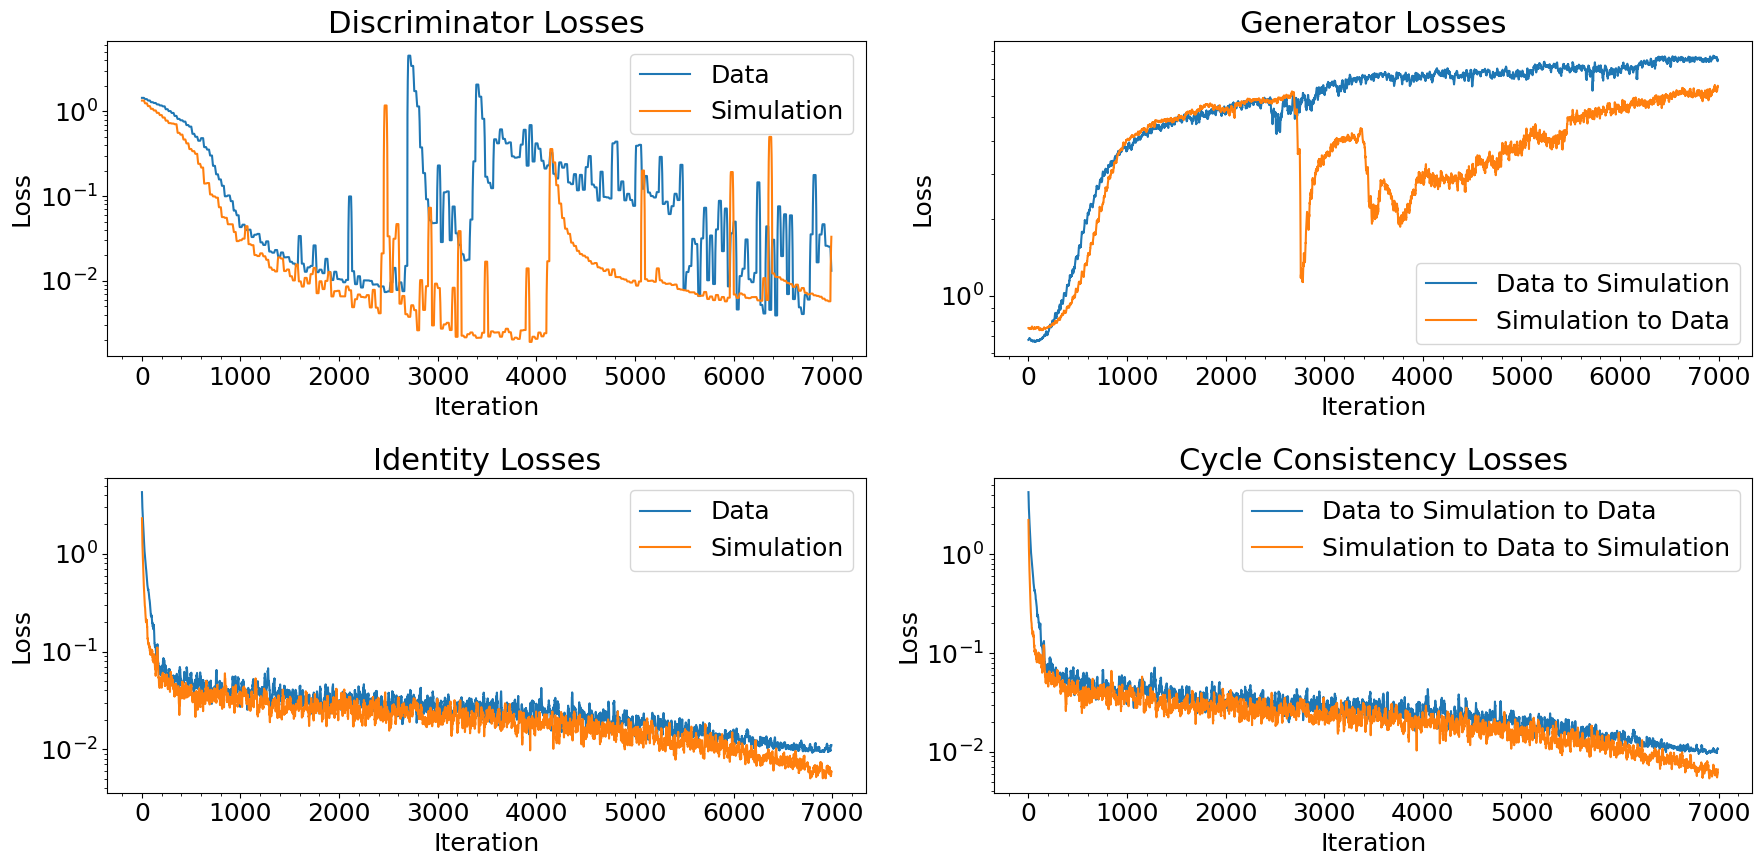

In [13]:
home_dir='/nas/longleaf/home/kbhimani/'

import numpy as np
import matplotlib.pyplot as plt

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# Load existing losses
losses_G = np.load(f"{home_dir}CPU-Net/plot_data/losses_G.npy")
losses_D_A = np.load(f"{home_dir}CPU-Net/plot_data/losses_D_A.npy")
losses_D_B = np.load(f"{home_dir}CPU-Net/plot_data/losses_D_B.npy")
losses_GAN_A2B = np.load(f"{home_dir}CPU-Net/plot_data/losses_GAN_A2B.npy")
losses_GAN_B2A = np.load(f"{home_dir}CPU-Net/plot_data/losses_GAN_B2A.npy")
losses_identity_A = np.load(f"{home_dir}CPU-Net/plot_data/losses_identity_A.npy")
losses_identity_B = np.load(f"{home_dir}CPU-Net/plot_data/losses_identity_B.npy")
losses_cycle_ABA = np.load(f"{home_dir}CPU-Net/plot_data/losses_cycle_ABA.npy")
losses_cycle_BAB = np.load(f"{home_dir}CPU-Net/plot_data/losses_cycle_BAB.npy")
# Set the moving average window
win = 10

# Create a figure with a grid of 2x3 subplots to include the new loss plots
plt.figure(figsize=(18, 9))
iterations = np.linspace(1,len(losses_G)-win+1,len(losses_G)-win+1)
plt.rcParams['font.size'] = 18
# plt.rcParams["figure.figsize"] = (9, 8)
cut = (iterations>0)

# Discriminator Losses
plt.subplot(2, 2, 1)
plt.plot(iterations[cut], moving_average(losses_D_A, win)[cut], label='Data')
plt.plot(iterations[cut], moving_average(losses_D_B, win)[cut], label='Simulation')
plt.title('Discriminator Losses', fontsize=22)
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.yscale('log')
plt.minorticks_on()
plt.legend()

# Generator Losses
plt.subplot(2, 2, 2)
plt.plot(iterations[cut], moving_average(losses_GAN_A2B/gan_loss_weight, win)[cut], label='Data to Simulation')
plt.plot(iterations[cut], moving_average(losses_GAN_B2A/gan_loss_weight, win)[cut], label='Simulation to Data')
plt.title('Generator Losses', fontsize=22)
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.yscale('log')
plt.minorticks_on()
plt.legend()

# Identity Losses
plt.subplot(2, 2, 3)
plt.plot(iterations, moving_average(losses_identity_A/iden_loss_weight, win), label='Data')
plt.plot(iterations, moving_average(losses_identity_B/iden_loss_weight, win), label='Simulation')
plt.title('Identity Losses', fontsize=22)
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.yscale('log')
plt.minorticks_on()
plt.legend()

# Cycle Consistency Losses
plt.subplot(2, 2, 4)
plt.plot(iterations, moving_average(losses_cycle_ABA/cyc_loss_weight, win), label='Data to Simulation to Data')
plt.plot(iterations, moving_average(losses_cycle_BAB/cyc_loss_weight, win), label='Simulation to Data to Simulation')
plt.title('Cycle Consistency Losses', fontsize=22)
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.yscale('log')
plt.minorticks_on()
plt.legend()

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('figs/loss_funcs.pdf')


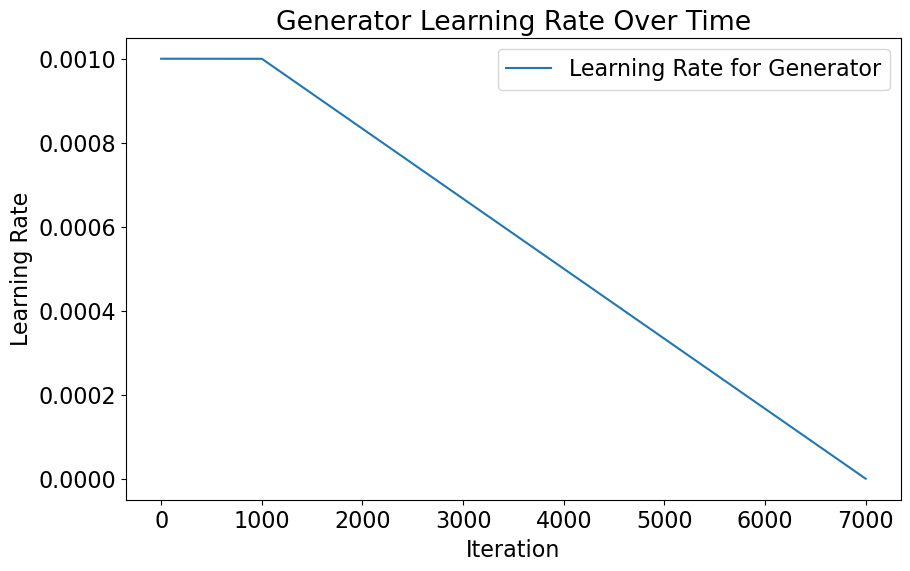

In [16]:
learning_rates_G = np.load(f"{home_dir}CPU-Net/plot_data/learning_rates_G.npy")
plt.figure(figsize=(10, 6))
plt.plot(learning_rates_G, label='Learning Rate for Generator')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('Generator Learning Rate Over Time')
plt.legend()

- Save trloss_disN and IATN

# Performance Validation and Plot
- Load the trained ATN into the device, the code run the model through training data, just how well it is translating the pulses
- See the Analysis notebook for validation on SEP and DEP

In [17]:
ATN = PositionalUNet()
ATN.to(DEVICE)
pretrained_dict = torch.load(f'{home_dir}CPU-Net/model_weights/{eng_peak}_ATN.pt')
# pretrained_dict = torch.load('fep_training/ATN_epoch_1.pt')
model_dict = ATN.state_dict()
model_dict.update(pretrained_dict) 
ATN.load_state_dict(pretrained_dict)
ATN.eval()
IATN = PositionalUNet()
IATN.to(DEVICE)
pretrained_dict_inv = torch.load(f'{home_dir}CPU-Net/model_weights/{eng_peak}_IATN.pt')
# pretrained_dict = torch.load('fep_training/ATN_epoch_1.pt')

model_dict_inv = IATN.state_dict()
model_dict_inv.update(pretrained_dict_inv) 
IATN.load_state_dict(pretrained_dict_inv)
IATN.eval()
data_dict_loader = train_loader

/tmp/ipykernel_8977/118485995.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(f'{home_dir}CPU-Net/model_weights/{eng_peak}_ATN.pt')
/tmp/ipy

- Read a single batch from the test loader, translating it through the ATN

In [18]:
wf, wf_deconv, a,b = next(iter(data_dict_loader))
wf = wf.to(DEVICE)
wf_deconv = wf_deconv.to(DEVICE)
outputs  = ATN(wf_deconv)
outputs_inv = IATN(outputs)
iwf = 2 # the ith waveform in the batch to plot
detector_pulse = wf[iwf,0,:].cpu().data.numpy().flatten()
simulated_pulse = wf_deconv[iwf,0,:].cpu().data.numpy().flatten()
translated_pulse = outputs[iwf,0,:].cpu().data.numpy().flatten()
translated_pulse_inv = outputs_inv[iwf,0,:].cpu().data.numpy().flatten()

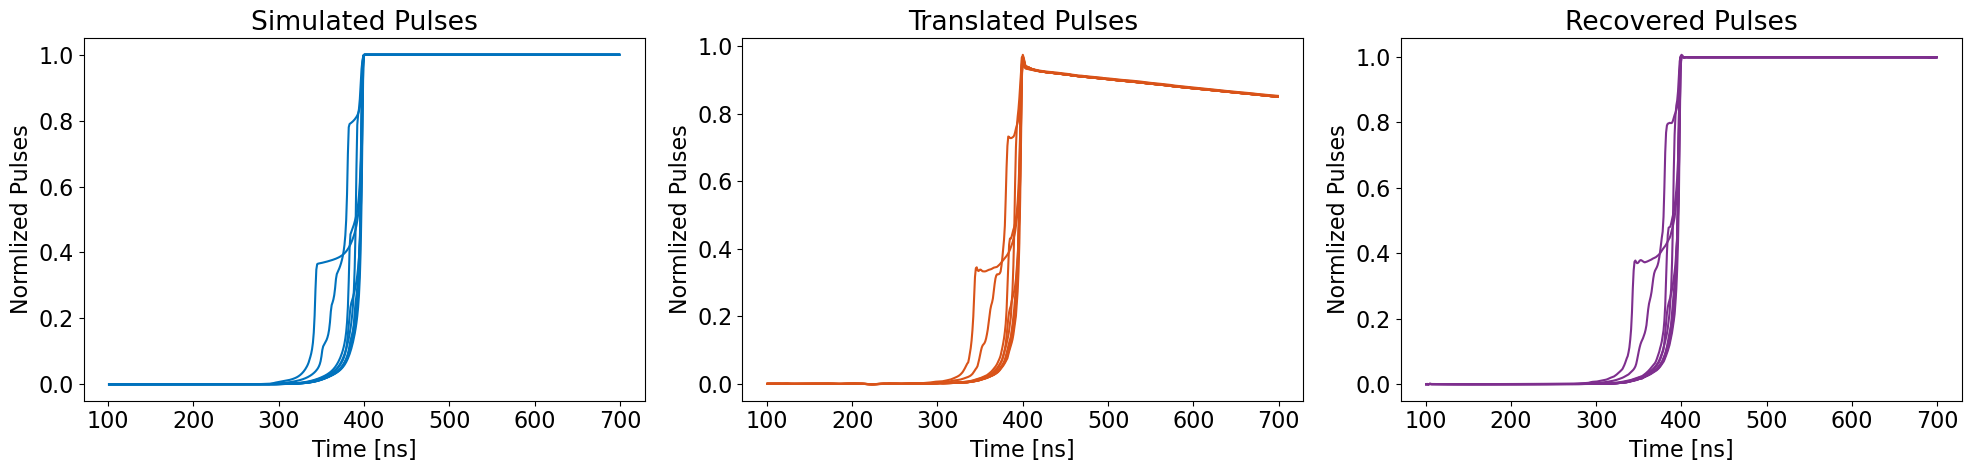

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cycle_BAB_with_style(netG_A2B, netG_B2A, train_loader, DEVICE, sample_rate=5, eng_peak="eng_peak", eng_peak_load="eng_peak_load"):
    # Initialize lists to store waveforms
    real_Bs, fake_As, recovered_Bs, real_As = [], [], [], []

    time = np.linspace(0, 799, 800)
    cut = (time > 100) & (time <700)

    # Loop over a fixed number of samples
    for _ in range(sample_rate):
        real_A, real_B, a, b = next(iter(train_loader))
        real_A = real_A.to(DEVICE)
        real_B = real_B.to(DEVICE)

        # Generate and recover
        with torch.no_grad():
            fake_A = netG_B2A(real_B)
            recovered_B = netG_A2B(fake_A)

        # Collect waveforms
        real_Bs.append(real_B[0, 0, :].cpu().numpy())
        fake_As.append(fake_A[0, 0, :].cpu().numpy())
        recovered_Bs.append(recovered_B[0, 0, :].cpu().numpy())
        real_As.append(real_A[0, 0, :].cpu().numpy())

       # Plotting
    colors = {
        "real_B": "#0072BD",  # bright blue
        "fake_A": "#D95319",  # bright orange
        "recovered_B": "#7E2F8E",  # purple
    }

    fig, axs = plt.subplots(1, 3, figsize=(20, 5))  
    titles = ["Simulated Pulses", "Translated Pulses", "Recovered Pulses"]
    waveform_lists = [real_Bs, fake_As, recovered_Bs]
    color_keys = ["real_B", "fake_A", "recovered_B"]

    for ax, title, waveforms, color_key in zip(axs, titles, waveform_lists, color_keys):
        for i in range(sample_rate):
            ax.plot(time[cut], waveforms[i][cut], color=colors[color_key], label=title if i == 0 else "")
        ax.set_title(title)
        ax.set_xlabel('Time [ns]')
        ax.set_ylabel('Normlized Pulses')
        # ax.legend(loc='upper right')

    fig.tight_layout()  # Adjust subplots to fit into the figure area.
    plt.savefig("figs/result_comp_1x3_cycle_BAB.png")
    plt.show()
    
plot_cycle_BAB_with_style(IATN, ATN, train_loader, DEVICE, sample_rate=10, eng_peak="SEP", eng_peak_load="DEP")

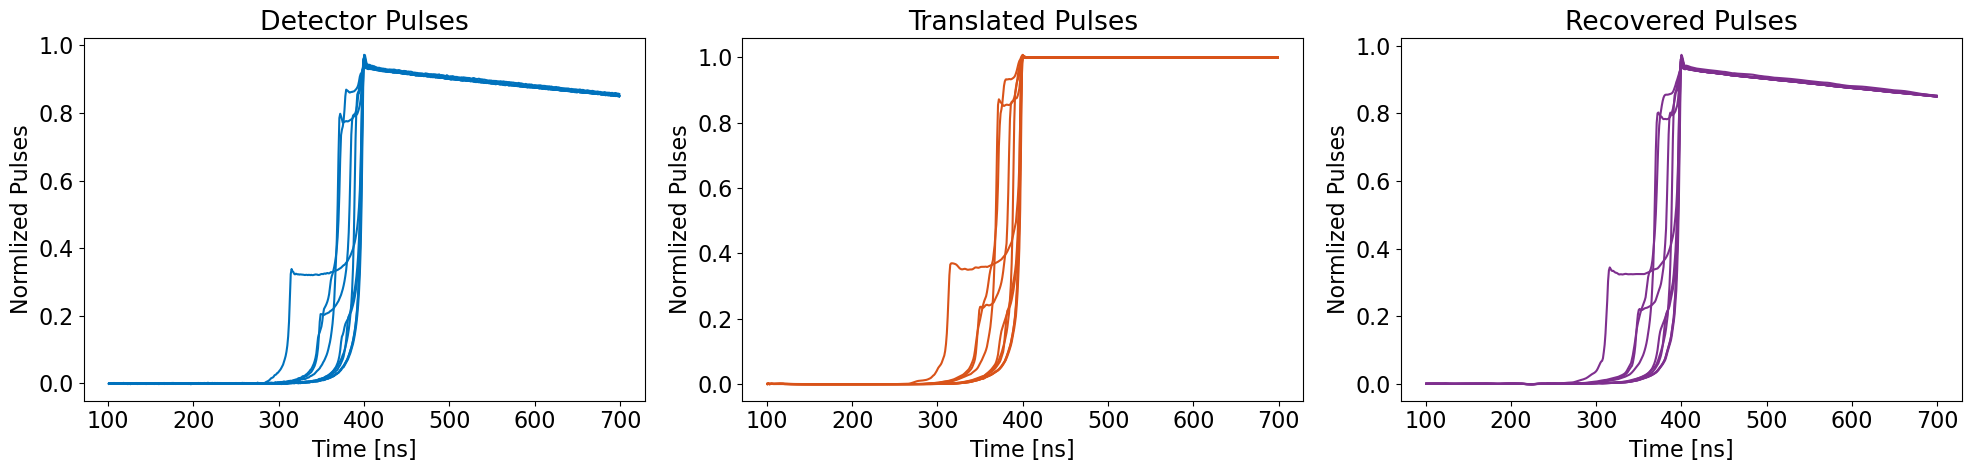

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_cycle_ABA_with_style(netG_A2B, netG_B2A, train_loader, DEVICE, sample_rate=5, eng_peak="eng_peak", eng_peak_load="eng_peak_load"):
    # Initialize lists to store waveforms
    real_As, fake_Bs, recovered_As = [], [], []

    time = np.linspace(0, 799, 800)
    cut = (time > 100) & (time <700) 

    # Loop over a fixed number of samples
    for _ in range(sample_rate):
        real_A, real_B,a,b = next(iter(train_loader))
        real_A = real_A.to(DEVICE)
        real_B = real_B.to(DEVICE)

        # Generate and recover
        with torch.no_grad():
            fake_B = netG_A2B(real_A)
            recovered_A = netG_B2A(fake_B)

        # Collect waveforms
        real_As.append(real_A[0, 0, :].cpu().numpy())
        fake_Bs.append(fake_B[0, 0, :].cpu().numpy())
        recovered_As.append(recovered_A[0, 0, :].cpu().numpy())

    # Plotting
    colors = {
        "real_A": "#0072BD",  # bright blue
        "fake_B": "#D95319",  # bright orange
        "recovered_A": "#7E2F8E",  # purple
    }

    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    titles = ["Detector Pulses", "Translated Pulses", "Recovered Pulses"]
    waveform_lists = [real_As, fake_Bs, recovered_As]
    color_keys = ["real_A", "fake_B", "recovered_A"]

    for ax, title, waveforms, color_key in zip(axs, titles, waveform_lists, color_keys):
        for i in range(sample_rate):
            ax.plot(time[cut], waveforms[i][cut], color=colors[color_key], label=title if i == 0 else "")
        ax.set_title(title)
        ax.set_xlabel('Time [ns]')
        ax.set_ylabel('Normlized Pulses')
        # ax.legend(loc='upper right')

    fig.tight_layout()  # Adjust subplots to fit into the figure area.
    plt.savefig("figs/result_comp_1x3_cycle_ABA.png")
    plt.show()

plot_cycle_ABA_with_style(IATN, ATN, train_loader, DEVICE, sample_rate=10, eng_peak="DEP", eng_peak_load="FEP")


In [21]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torch

# def visualize_attention_weights_for_both(model_A, model_B, weights_path_A, weights_path_B, test_loader, device):
#     # Load the saved weights for both models
#     model_A.load_state_dict(torch.load(weights_path_A, map_location=device))
#     model_B.load_state_dict(torch.load(weights_path_B, map_location=device))
    
#     # Set both models to evaluation mode
#     model_A.eval()
#     model_B.eval()
    
#     # Get a single batch from the test loader
#     real_A, real_B, a,b = next(iter(test_loader))
    
#     # Assume real_A and real_B are already on the correct device and normalized if necessary
#     real_A = real_A.to(device)
#     real_B = real_B.to(device)

#     # Get the attention weights for the single input instance from both models
#     with torch.no_grad():
#         attention_weights_A = model_A.get_attention_weights(real_A).cpu().numpy()[0]  # Assuming a method that returns attention weights
#         attention_weights_B = model_B.get_attention_weights(real_B).cpu().numpy()[0]  # Assuming a method that returns attention weights

#     time_intervals = [(0, 201, 'tab:blue'), (200, 451, 'tab:red'), (451, 800, 'tab:green')]
#     detector_pulses= real_A[0].cpu().numpy()[0]
#     simulated_pulses=real_B[0].cpu().numpy()[0]
#     # Create figure for visualization
#     fig, axs = plt.subplots(2, 2, figsize=(20, 10))  # Two rows for waveforms and attention, two columns for each model
    
#     # Plot waveform and attention weights for model A (Detector Pulses)
#     for start, end, color in time_intervals:
#         axs[0, 0].plot(np.arange(start, min(end, len(detector_pulses))), detector_pulses[start:end], color=color, label=f'{start}-{end} ns')
#     axs[0, 0].set_title('Detector Pulses')
#     axs[0, 0].legend()

#     axs[1, 0].plot(attention_weights_A, label='Attention Weights A')
#     axs[1, 0].set_title('Attention Weights (Detector Pulses)')
#     axs[1, 0].legend()

#     # Plot waveform and attention weights for model B (Simulated Pulses)
#     for start, end, color in time_intervals:
#         axs[0, 1].plot(np.arange(start, min(end, len(simulated_pulses))), simulated_pulses[start:end], color=color, label=f'{start}-{end} ns') 
#     axs[0, 1].set_title('Simulated Pulses')
#     axs[0, 1].legend()

#     axs[1, 1].plot(attention_weights_B, label='Attention Weights B')
#     axs[1, 1].set_title('Attention Weights (Simulated Pulses)')
#     axs[1, 1].legend()
    
#     # Adjust layout and display the plot
#     plt.tight_layout()
#     # plt.savefig("figs/attention_wf_plot_both.png", dpi=200)
#     plt.show()
    
# netD_A = RNN(get_attention=True)
# netD_B = RNN(get_attention=True)
# weights_path_A = f'model_weights/{eng_peak}_netD_A.pth'
# weights_path_B = f'model_weights/{eng_peak}_netD_B.pth'

# # Now call the function to visualize the attention weights for both models
# visualize_attention_weights_for_both(netD_A, netD_B, weights_path_A, weights_path_B, train_loader,'cpu')

- Plot simulated pulses, data pulses and translated pulses in the same plot.

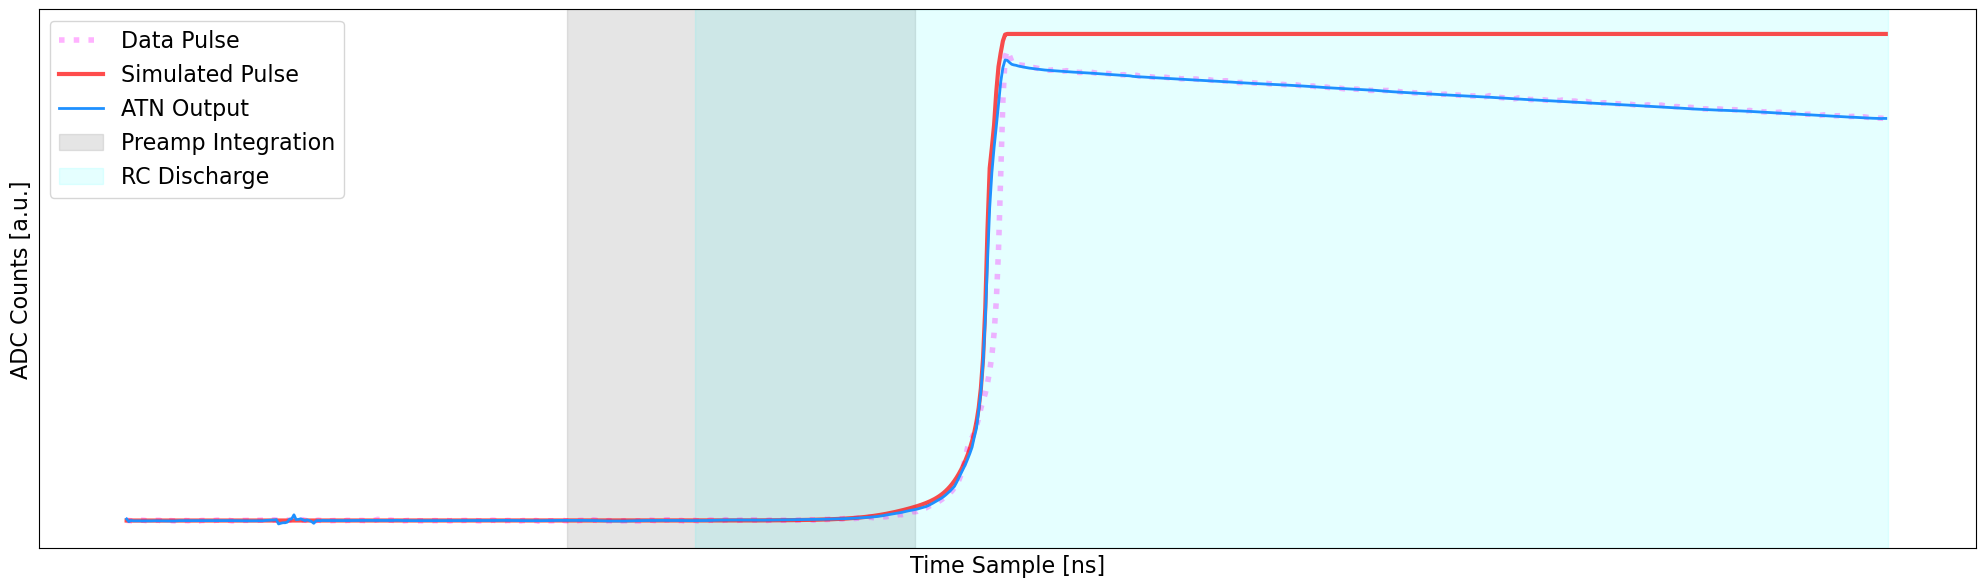

In [22]:
wf, wf_deconv, a, b = next(iter(data_dict_loader))
wf = wf.to(DEVICE)
wf_deconv = wf_deconv.to(DEVICE)
outputs  = ATN(wf_deconv)
outputs_inv = IATN(outputs)
iwf = 2 # the ith waveform in the batch to plot
detector_pulse = wf[iwf,0,:].cpu().data.numpy().flatten()
simulated_pulse = wf_deconv[iwf,0,:].cpu().data.numpy().flatten()
translated_pulse = outputs[iwf,0,:].cpu().data.numpy().flatten()
translated_pulse_inv = outputs_inv[iwf,0,:].cpu().data.numpy().flatten()
fig = plt.figure(figsize=(25, 7))
plt.plot(detector_pulse, label="Data Pulse",alpha=0.3, color="magenta", linestyle=":",linewidth = 4)
plt.plot(simulated_pulse, label="Simulated Pulse",alpha=0.7, color="red", linewidth = 3)
plt.plot(translated_pulse, label="ATN Output",color="dodgerblue", linewidth = 2)
plt.axvspan(xmin=200,xmax=358,alpha=0.2,color="grey", label="Preamp Integration")
plt.axvspan(xmin=258,xmax=800,alpha=0.1,color="cyan",label="RC Discharge")
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel("Time Sample [ns]")
plt.ylabel("ADC Counts [a.u.]")
# ax_main.plot(orwf, label="Data->Siggen",alpha=0.3,color="green", linewidth = 5)
# plt.gca().get_xaxis().set_visible(False)
# plt.gca().get_yaxis().set_visible(False)
plt.legend(loc="upper left")
# plt.xlim(200, 600)
# plt.savefig("figs/ATN.png",dpi=200)
plt.show()
plt.cla()
plt.clf()
plt.close()

- Obtain the critical reconstruction parameters of each waveform by looping through the test dataset
    - `ca`: maximal current amplitude
    - `ts`: tail slope

In [23]:
ts = []
gan_ts = []
ca = []
gan_ca = []
sim_ca = []
data_wf= []
siggen_wf= []
i=0
for wf, wf_deconv,rawwf, x in tqdm(train_loader):
    bsize = wf.size(0)
    gan_wf = ATN(wf_deconv.to(DEVICE).float())
    if i>5000:
        break
    for iwf in range(bsize):
        datawf = wf[iwf,0].cpu().numpy().flatten()
        siggenwf = wf_deconv[iwf,0].cpu().numpy().flatten()
        transfer_wf = gan_wf[iwf,0].detach().cpu().numpy().flatten()
        ts.append(get_tail_slope(datawf))
        gan_ts.append(get_tail_slope(transfer_wf))
        ca.append(calc_current_amplitude(datawf))
        gan_ca.append(calc_current_amplitude(transfer_wf))
        sim_ca.append(calc_current_amplitude(siggenwf))
        siggen_wf.append(siggenwf)
        data_wf.append(datawf)
        i += 1


  5%|▍         | 157/3354 [00:10<03:29, 15.27it/s]


In [24]:
print(len(ts))
print(len(gan_ts))
print('Mean data tau', np.mean(ts))
print('Mean GAN tau', np.mean(gan_ts))
print('STD data tau', np.std(ts))
print('STD GAN tau', np.std(gan_ts))

5024
5024
Mean data tau -0.00029307462465686643
Mean GAN tau -0.0002978020803860062
STD data tau 8.353206033011323e-07
STD GAN tau 4.896281665761581e-06


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

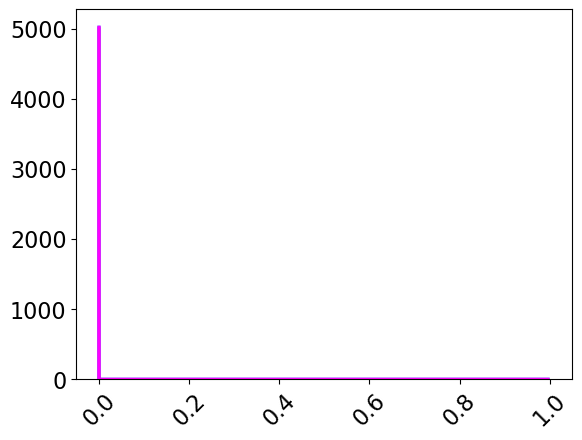

In [25]:
log_status = False #histtype="step"
rg = np.linspace(-40e-5,1,1000)
plt.hist(ts,bins=rg, histtype="step", log=log_status,linewidth=2, alpha=1, color="dodgerblue",label="Detector Pulse")
plt.hist(gan_ts,bins=rg, histtype="step", log=log_status,linewidth=2, alpha=1,color="magenta",label="Translated Pulse")
# plt.axvline(train_stop_slope)
# plt.axvline(x=0)
plt.xticks(rotation=45)

- Plotting the normalized tail slope

Tail slope IoU between Detector Peak and Translated Peak: 0.5256121631


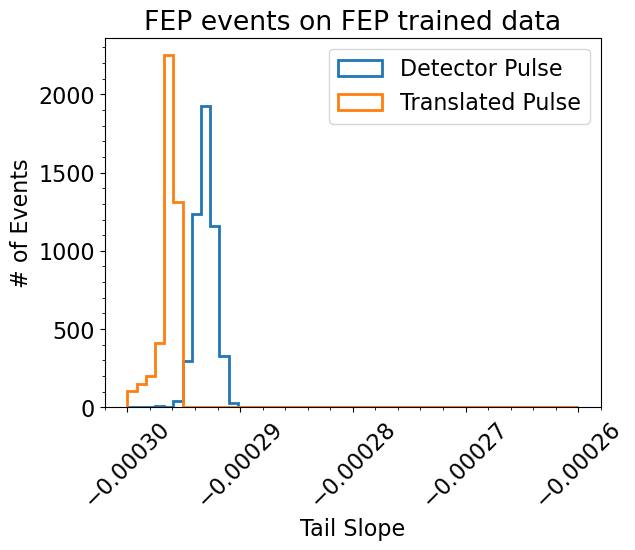

In [26]:
rg = np.linspace(-30e-5,-26e-5,50)

log_status = False
plt.hist(ts,bins=rg,histtype="step",linewidth=2,log=log_status, color="#1f77b4",label="Detector Pulse")
plt.hist(gan_ts,bins=rg,histtype="step",linewidth=2,log=log_status, color="#ff7f0e",label="Translated Pulse")
# plt.axvline(x=0,color="#2ca02c",linewidth=3,label="Simulated Pulse")
# plt.xlim(-5,8)
plt.legend()
plt.title(f"{eng_peak.upper()} events on {eng_peak.upper()} trained data")
plt.ylabel("# of Events")
plt.xlabel("Tail Slope")
# plt.savefig("figs/tailslope.png",dpi=200)
# Calculate the histograms (with density=True to normalize the histograms)
plt.legend()
plt.xticks()  
plt.yticks()
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.axvline(x=0)
plt.minorticks_on()
plt.xticks(rotation=45)
print(f"Tail slope IoU between Detector Peak and Translated Peak: {calculate_iou(ts, gan_ts, rg, normed=False):.10f}")

# plt.savefig(f"figs/{eng_peak.upper()}_ts.pdf")


- Plotting the maximal current amplitude

IoU between Detector Peak and Simulated Peak: 37.7121567630
IoU between Detector Peak and Translated Peak: 74.2032451377


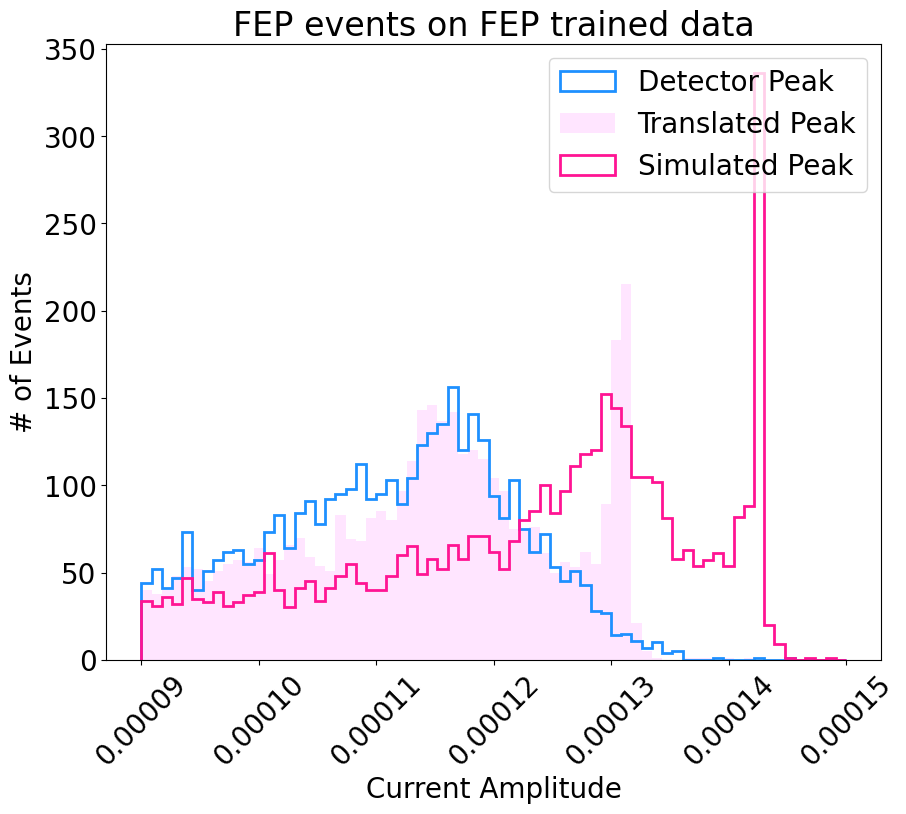

In [27]:
plt.rcParams['font.size'] = 20
plt.rcParams["figure.figsize"] = (10,8)
# rg = np.linspace(0.000125, 0.00015, 50)
rg = np.linspace(0.00009, 0.00015, 70)
plt.hist(ca,label="Detector Peak",bins=rg, histtype="step",linewidth=2,color="dodgerblue")
plt.hist(gan_ca,label="Translated Peak",bins=rg,alpha=0.1,color="magenta")
plt.hist(sim_ca,label="Simulated Peak",bins=rg,linewidth=2,histtype="step",color="deeppink")
plt.xlabel("Current Amplitude")
plt.xticks(rotation=45)
plt.ylabel("# of Events")
plt.title(f"{eng_peak.upper()} events on {eng_peak.upper()} trained data")
plt.legend(loc="upper right")


print(f"IoU between Detector Peak and Simulated Peak: {calculate_iou(ca, sim_ca, rg, normed=False):.10f}")
print(f"IoU between Detector Peak and Translated Peak: {calculate_iou(ca, gan_ca, rg, normed=False):.10f}")

# plt.yscale("log")
# plt.savefig("figs/dep_current_amp.png",dpi=200)

In [4]:
#Zip the file, mkaing it easier to download
import shutil

folder_path = "/nas/longleaf/home/kbhimani/CPU-Net"
zip_path = "/nas/longleaf/home/kbhimani/CPU-Net.zip"

# Compress the folder
shutil.make_archive(zip_path.replace(".zip", ""), 'zip', folder_path)

print("Folder zipped successfully!")

Folder zipped successfully!
